In [40]:
import os
print(os.getcwd())

/Users/aman/bioinformatics-portfolio/scRNAseq-PBMC/notebooks


In [41]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Set verbosity and figure options
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

# Load the dataset
adata = sc.read_10x_mtx(
    "../data/raw_gene_bc_matrices/hg19/",
    var_names="gene_symbols",
    cache=True
)
print(adata)

... reading from cache file cache/..-data-raw_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 737280 × 32738
    var: 'gene_ids'


In [42]:
# View the first few observations (cells)
print(adata.obs_names[:5])

# View the first few gene names
print(adata.var_names[:5])

# Show summary stats
adata.X.shape

Index(['AAACATACAAAACG-1', 'AAACATACAAAAGC-1', 'AAACATACAAACAG-1',
       'AAACATACAAACGA-1', 'AAACATACAAAGCA-1'],
      dtype='object')
Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8'], dtype='object')


(737280, 32738)

In [43]:
# Add QC metrics to AnnData object
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # Identify mitochondrial genes

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

# Quick look at QC metrics
adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head()

,total_counts,n_genes_by_counts,pct_counts_mt
AAACATACAAAACG-1,10.0,9,0.0
AAACATACAAAAGC-1,0.0,0,NaN
AAACATACAAACAG-1,0.0,0,NaN
AAACATACAAACGA-1,6.0,6,0.0
AAACATACAAAGCA-1,6.0,6,0.0


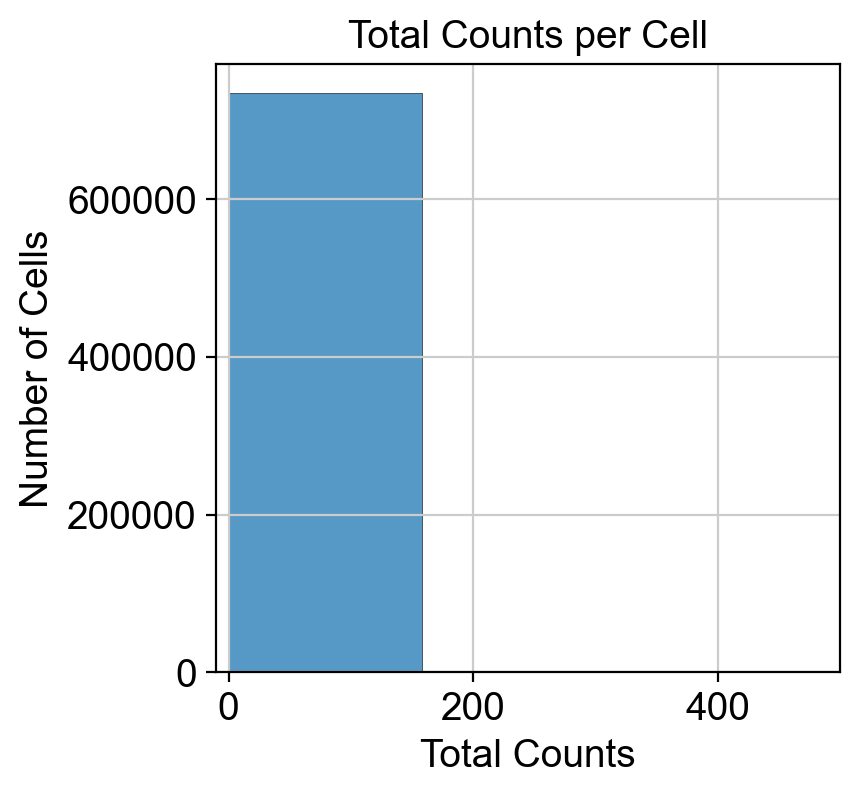

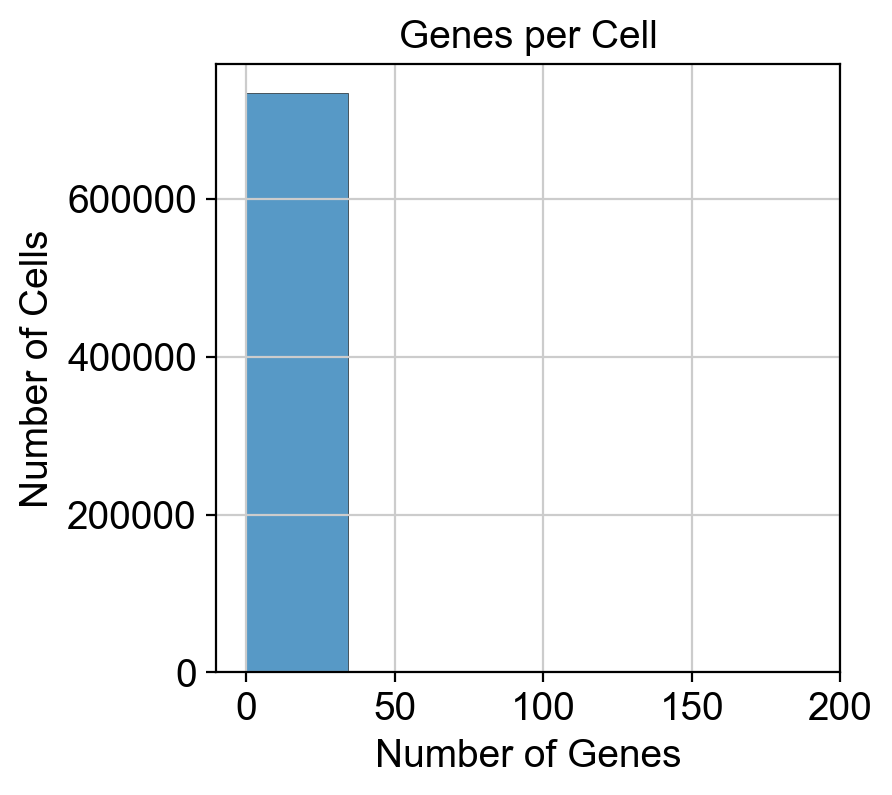

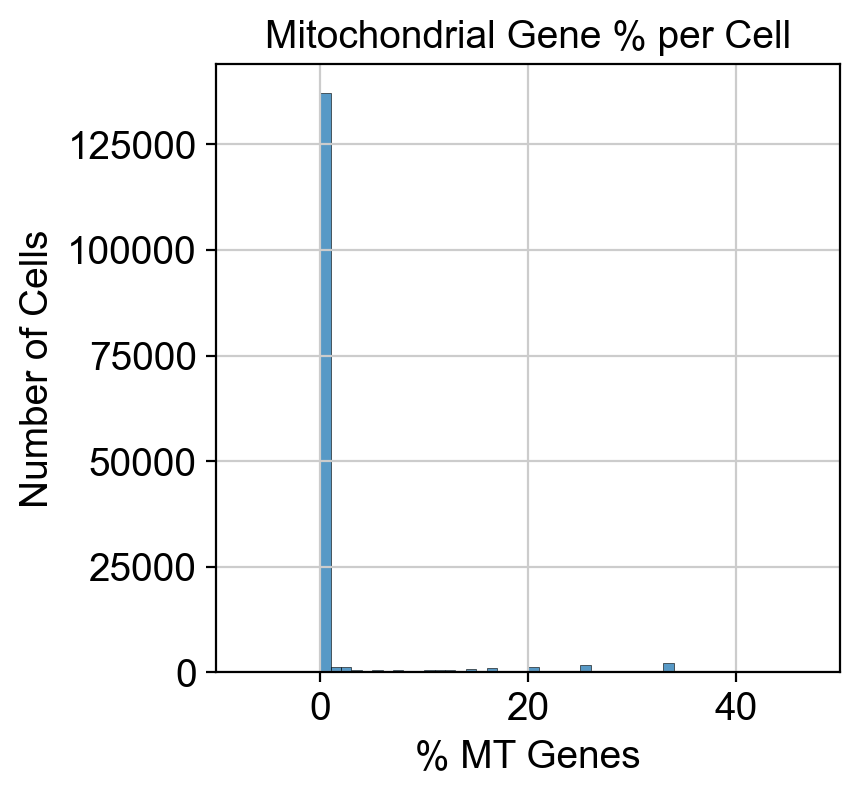

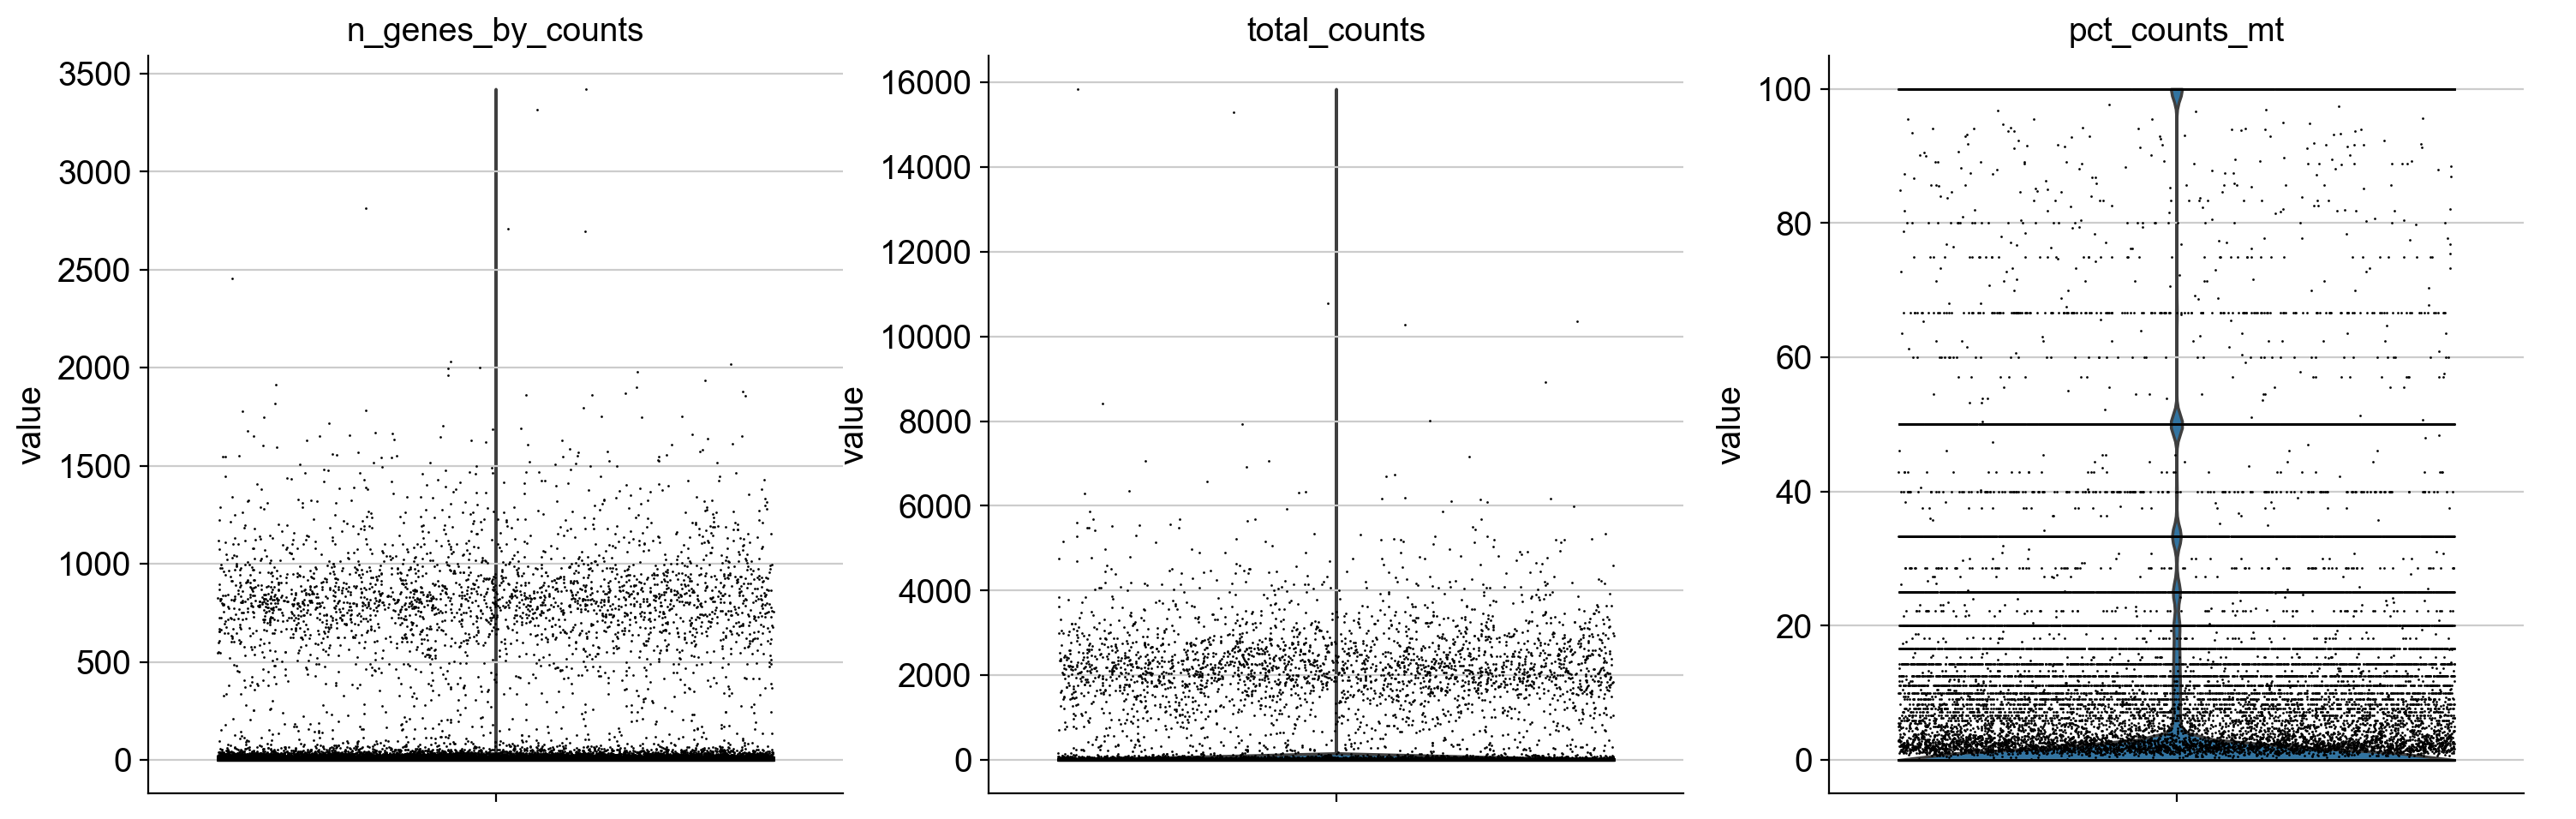

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of total counts
sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
plt.title("Total Counts per Cell")
plt.xlabel("Total Counts")
plt.ylabel("Number of Cells")
plt.xlim(-10, 500)
plt.show()

# Number of genes detected per cell
sns.histplot(adata.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title("Genes per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.xlim(-10, 200)
plt.show()

# % mitochondrial gene counts
sns.histplot(adata.obs["pct_counts_mt"], bins=100, kde=False)
plt.title("Mitochondrial Gene % per Cell")
plt.xlabel("% MT Genes")
plt.ylabel("Number of Cells")
plt.xlim(-10, 50)
plt.show()

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True, show=False)

In [45]:
# Keep cells with:
# - At least 200 genes
# - No more than 5% mitochondrial gene expression
# - And less than 6,000 genes (to remove likely doublets)

sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs["pct_counts_mt"] < 5, :]
adata = adata[adata.obs["n_genes_by_counts"] < 6000, :]

# Also filter genes detected in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=10)

# Check shape again
adata.shape

# Save the filtered AnnData object
adata.write("../data/pbmc3k_filtered.h5ad")


filtered out 734529 cells that have less than 200 genes expressed
filtered out 19032 genes that are detected in less than 3 cells
filtered out 2463 genes that are detected in less than 10 counts


/Users/aman/bioinformatics-portfolio/venv/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50


/Users/aman/bioinformatics-portfolio/venv/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:929: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:02)


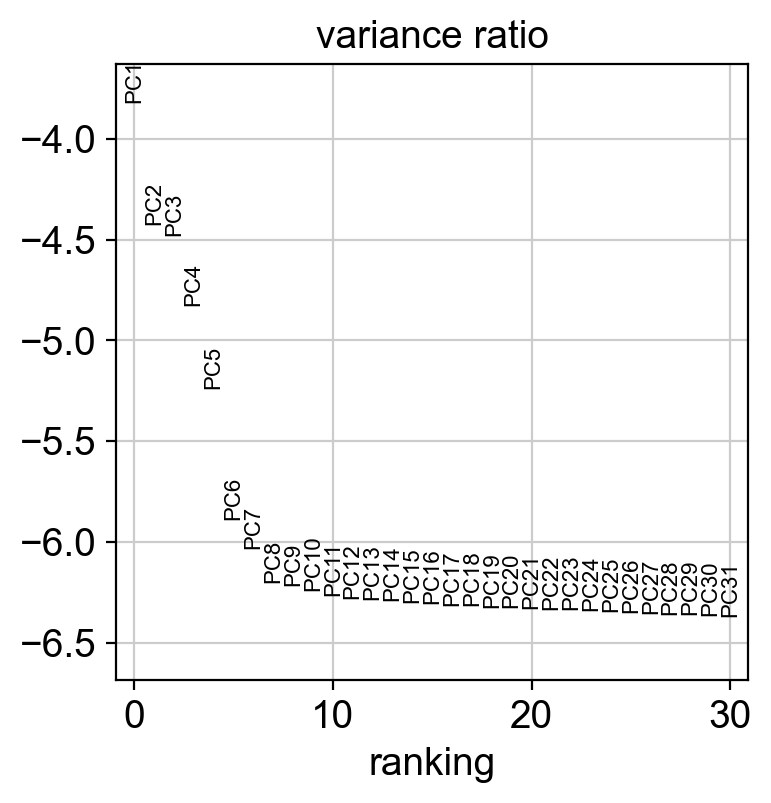

In [46]:
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)
adata.raw = adata  # Save log-normalized data before scaling

# Identify the 2,000 most variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot explained variance
sc.pl.pca_variance_ratio(adata, log=True)

In [47]:
import scanpy as sc

sc.pp.neighbors(adata, n_pcs=15, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


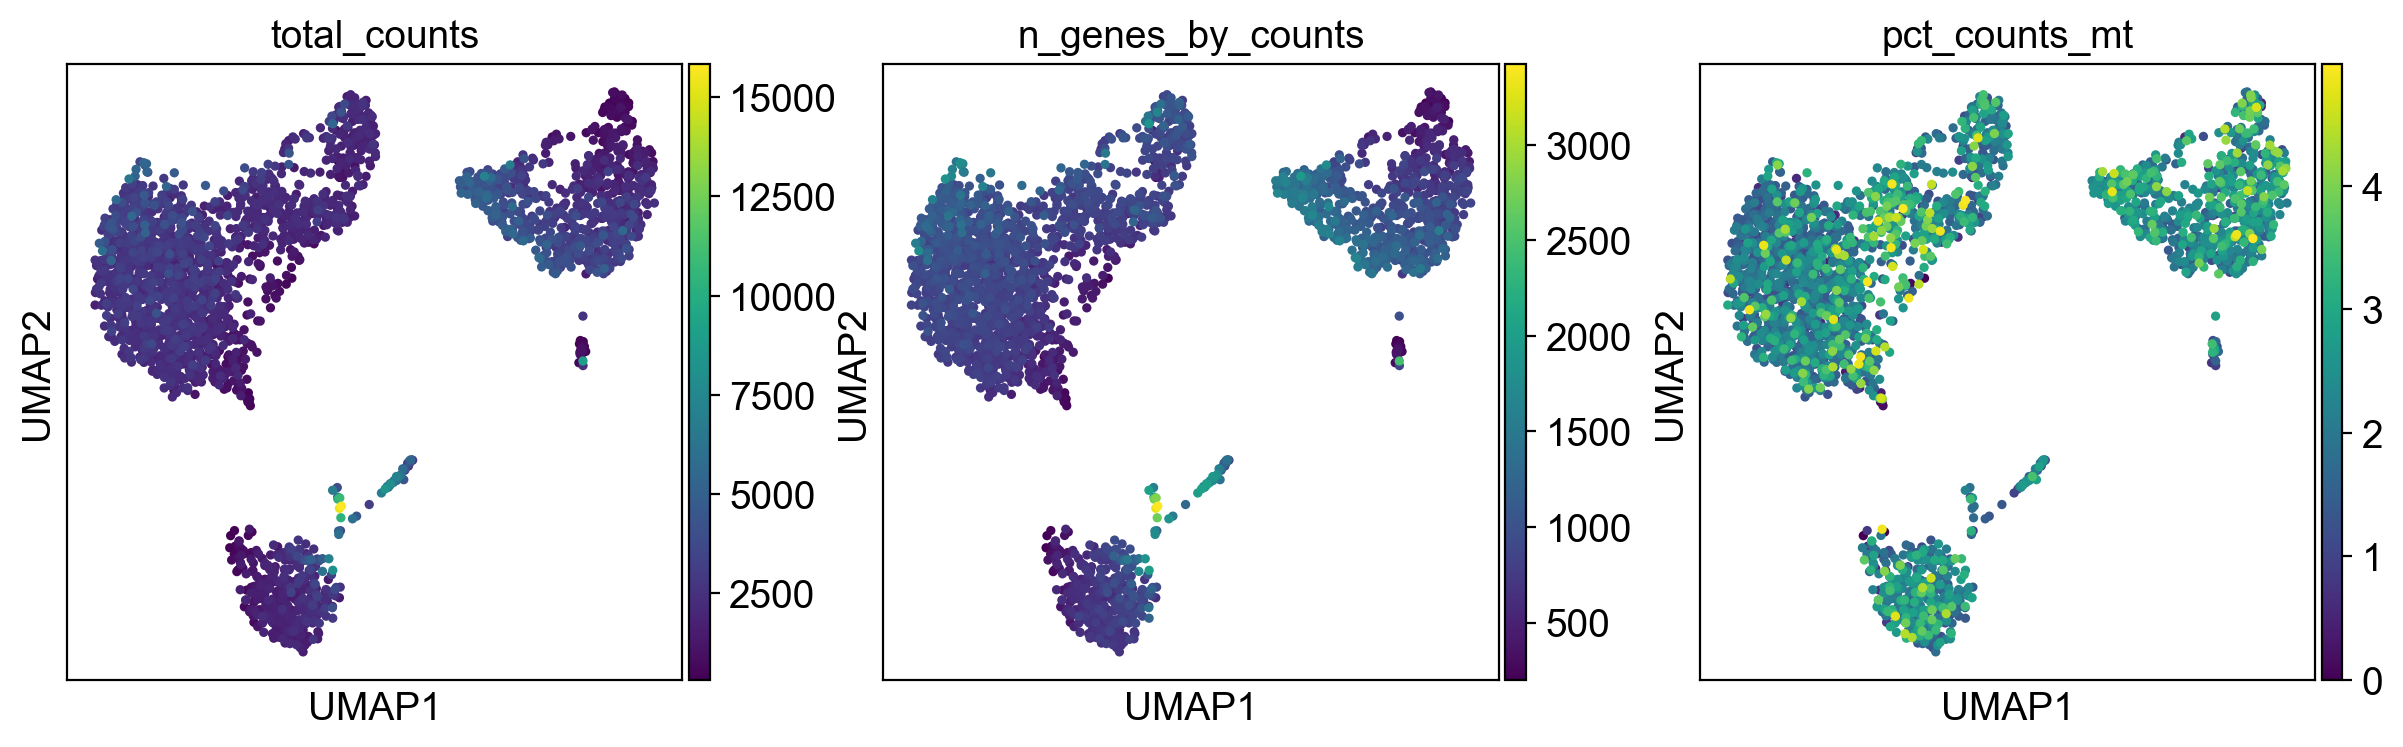

In [61]:
#Run UMAP for Visualization
sc.tl.umap(adata)
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'])

In [49]:
!pip install igraph leidenalg

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


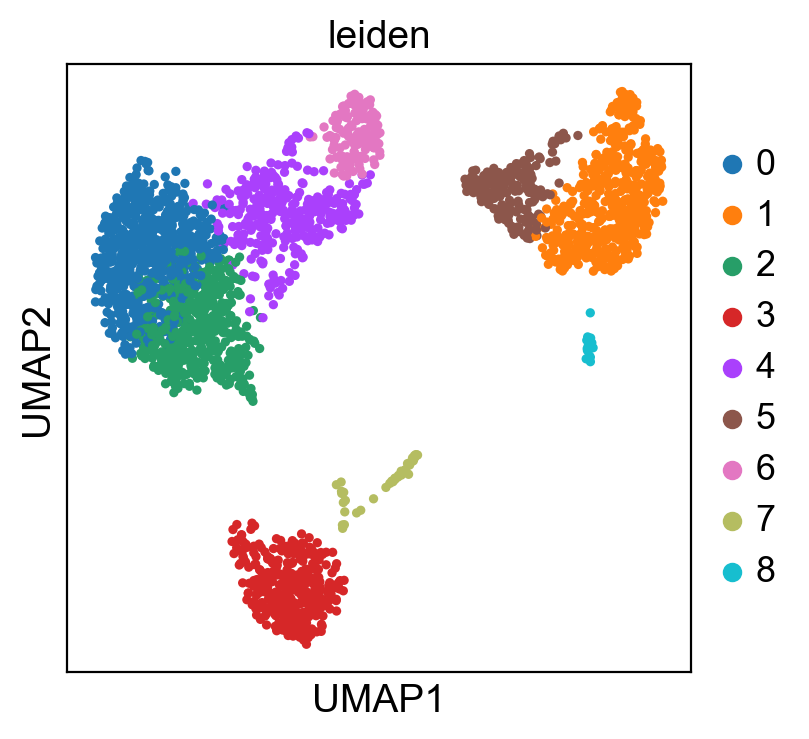

In [50]:
#Louvain or Leiden algorithms to group similar cells into discrete clusters

# Remove the old color mapping
if 'leiden_colors' in adata.uns:
    del adata.uns['leiden_colors']

sc.tl.leiden(adata, resolution=0.7)  # resolution controls number of clusters
sc.pl.umap(adata, color='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


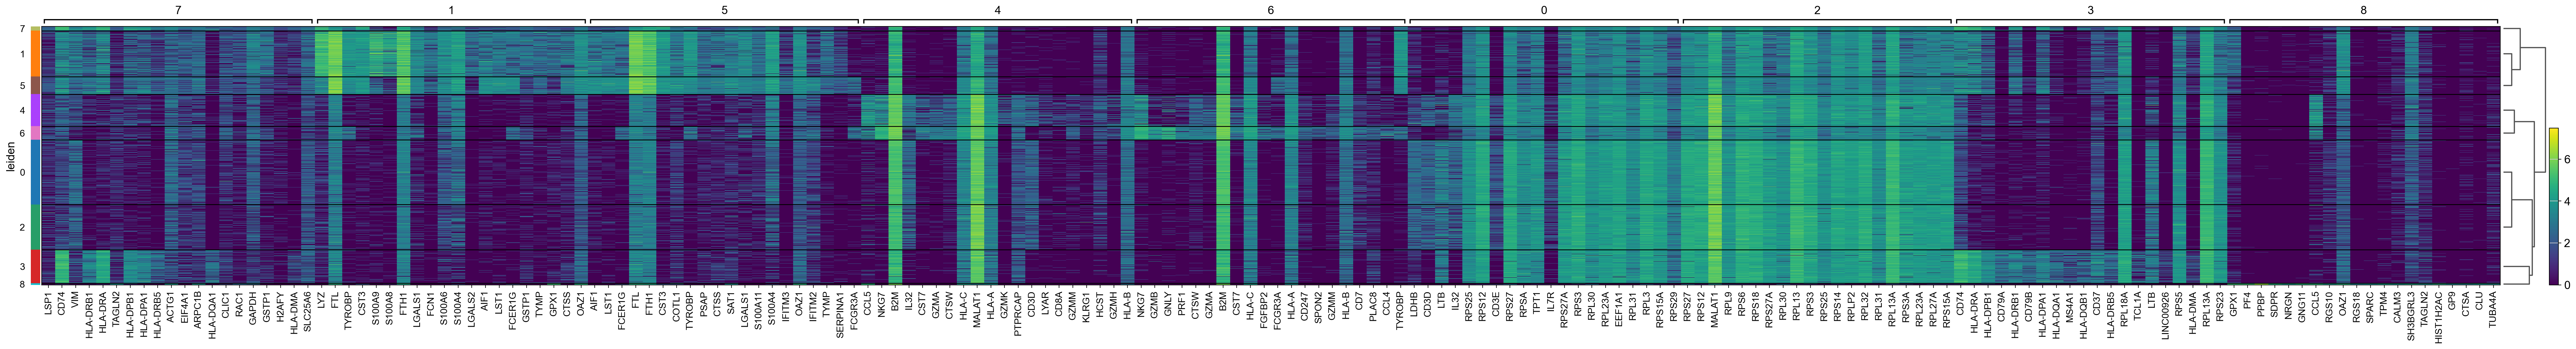

In [51]:
# Perform differential expression to find marker genes for each Leiden cluster
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test', use_raw=True)

# Visualize top 20 marker genes using a heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, show_gene_labels=True)

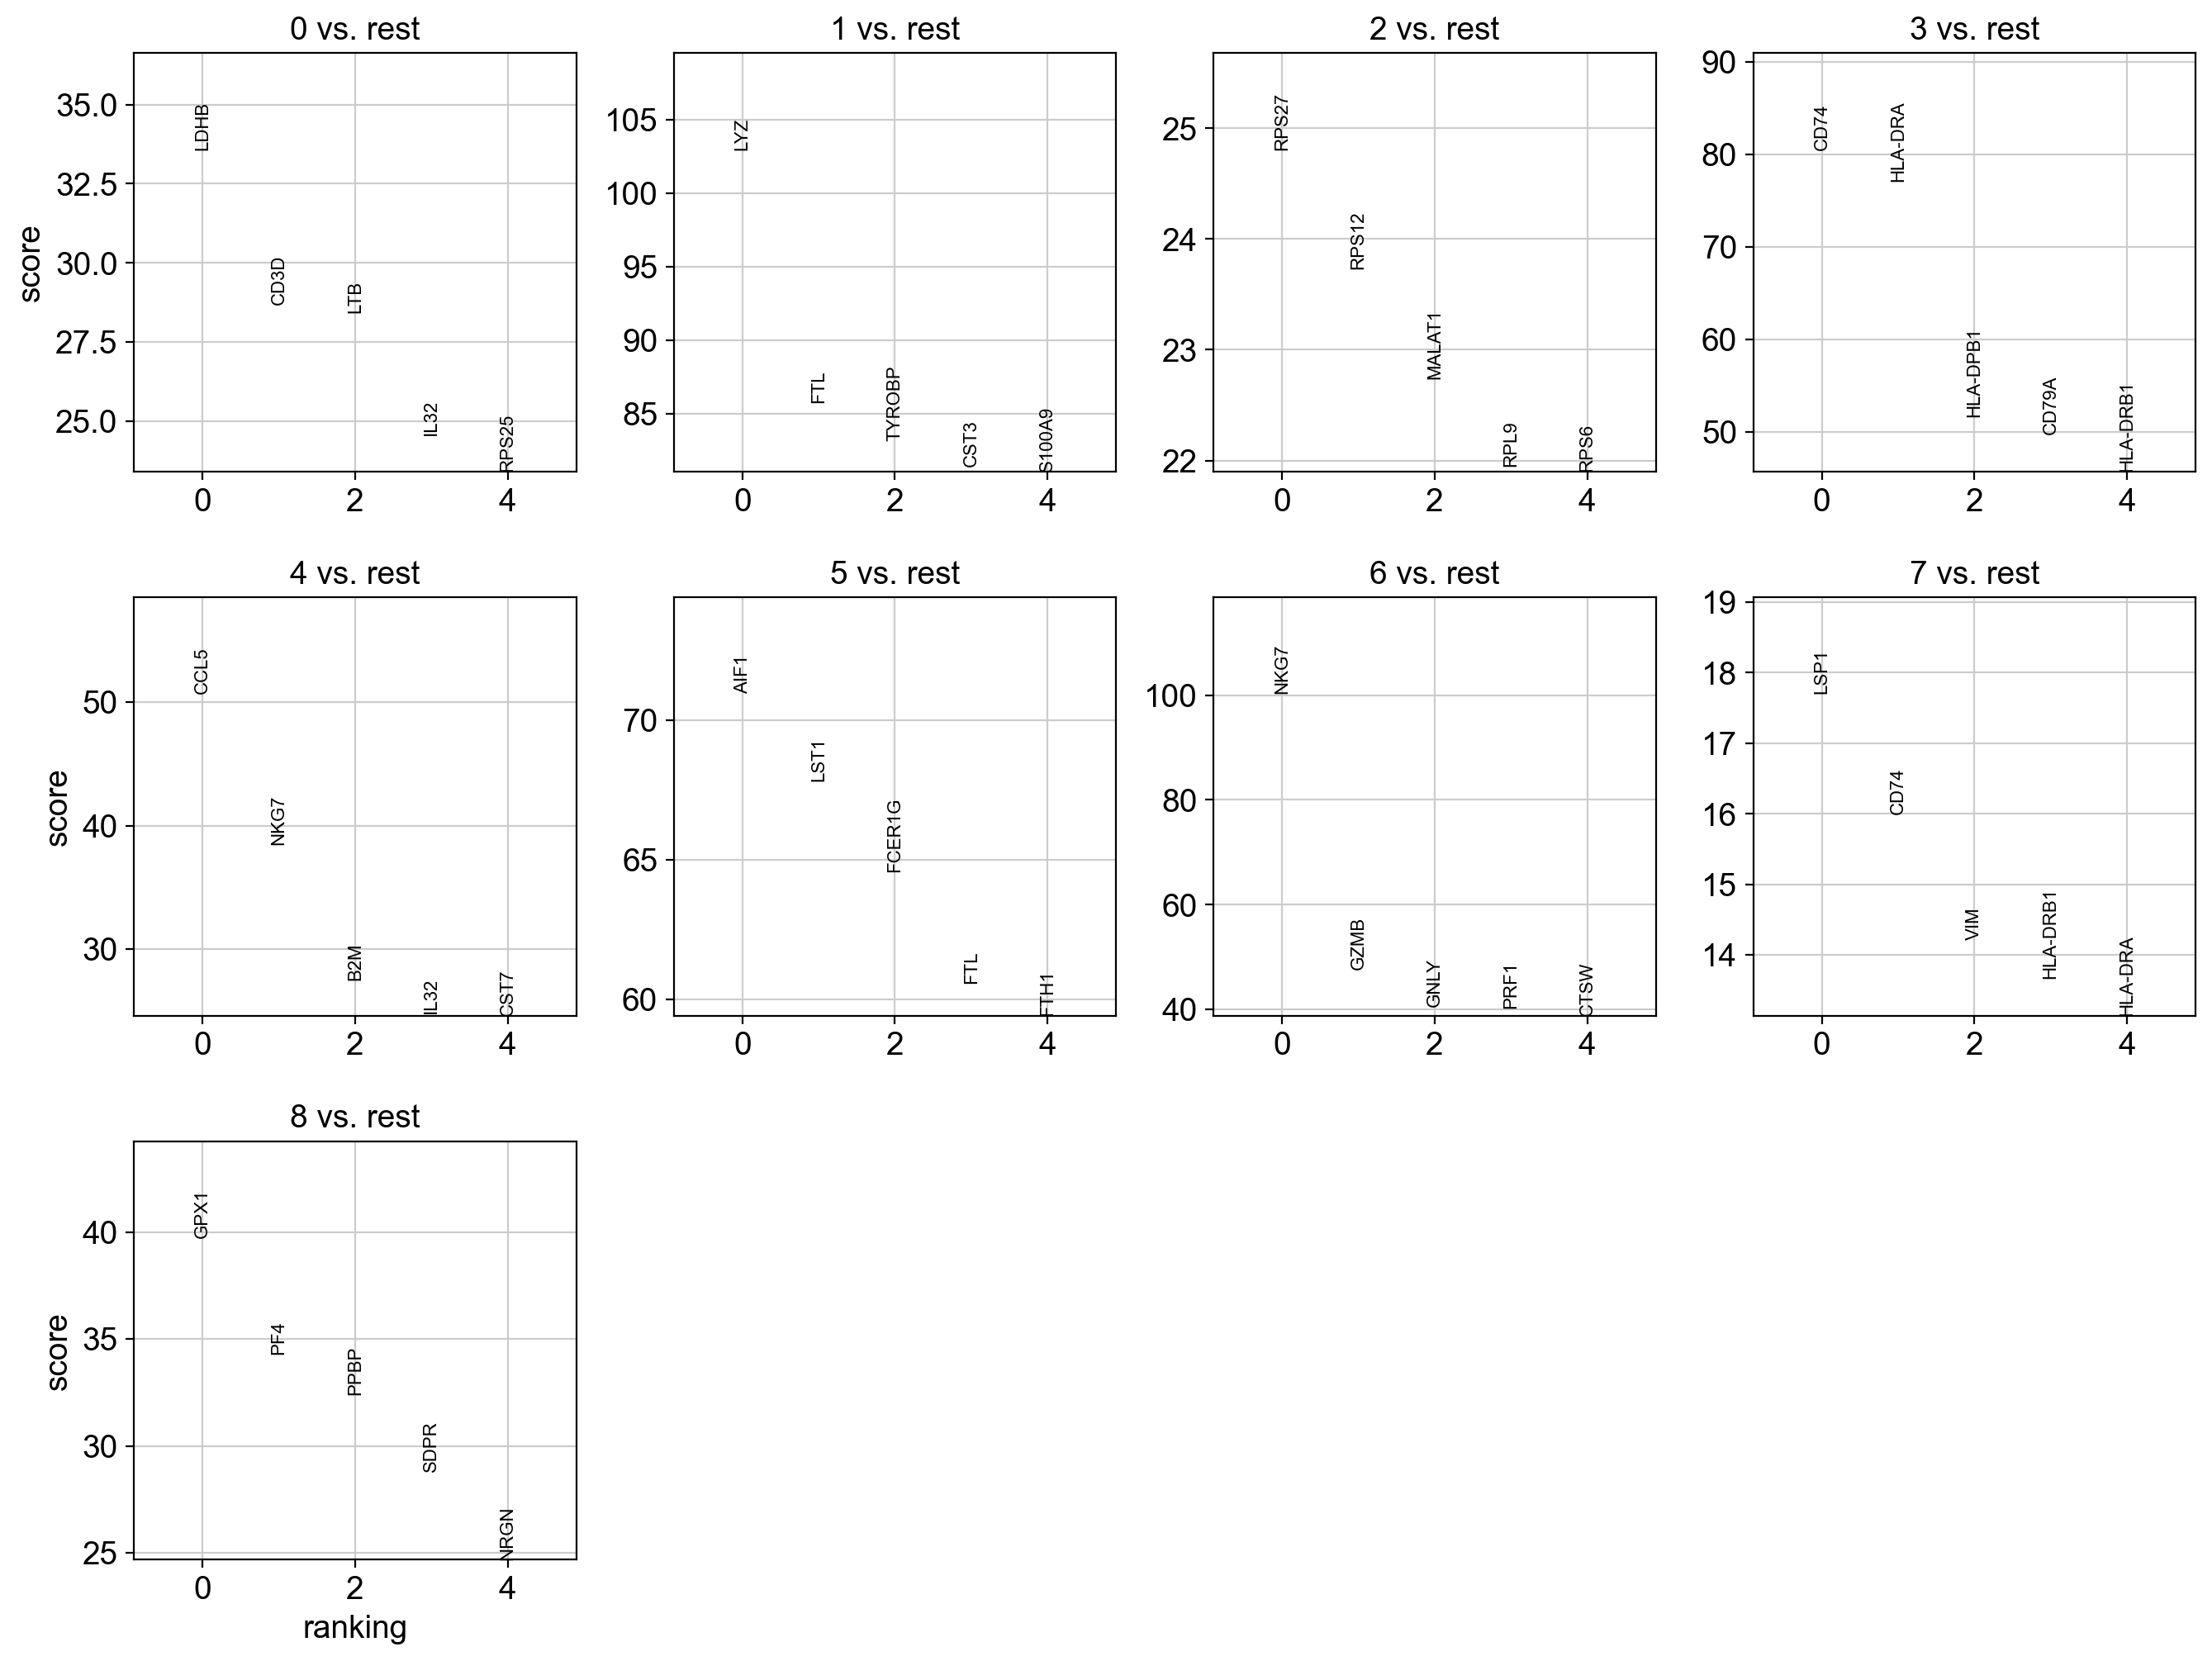

In [52]:
#summary plots of top genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

import pandas as pd

# Extract marker gene results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names  # cluster names (e.g., '0', '1', '2', ...)
top_n = 5  # top 5 genes

# Collect rows in a list
rows = []

for group in groups:
    for i in range(top_n):
        rows.append({
            'cluster': group,
            'gene': result['names'][group][i],
            'logfoldchange': result['logfoldchanges'][group][i],
            'score': result['scores'][group][i],
            'pval': result['pvals'][group][i],
            'pval_adj': result['pvals_adj'][group][i]
        })

# Convert to DataFrame
long_df = pd.DataFrame(rows)

# Save to CSV
long_df.to_csv("../results/top5_marker_genes_long_format.csv", index=False)


In [53]:
# Define custom names for each cluster
cluster_to_celltype = {
    '0': 'Activated T cells',
    '1': 'Monocytes / Macrophages',
    '2': 'Ribosomal-rich (Proliferative)',
    '3': 'B cells / APCs',
    '4': 'Cytotoxic Lymphocytes (CD8+/NK)',
    '5': 'Macrophages (Myeloid)',
    '6': 'Cytotoxic NK / CD8+ T cells',
    '7': 'Dendritic cells / APCs',
    '8': 'Platelets',
}


# Apply the mapping
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

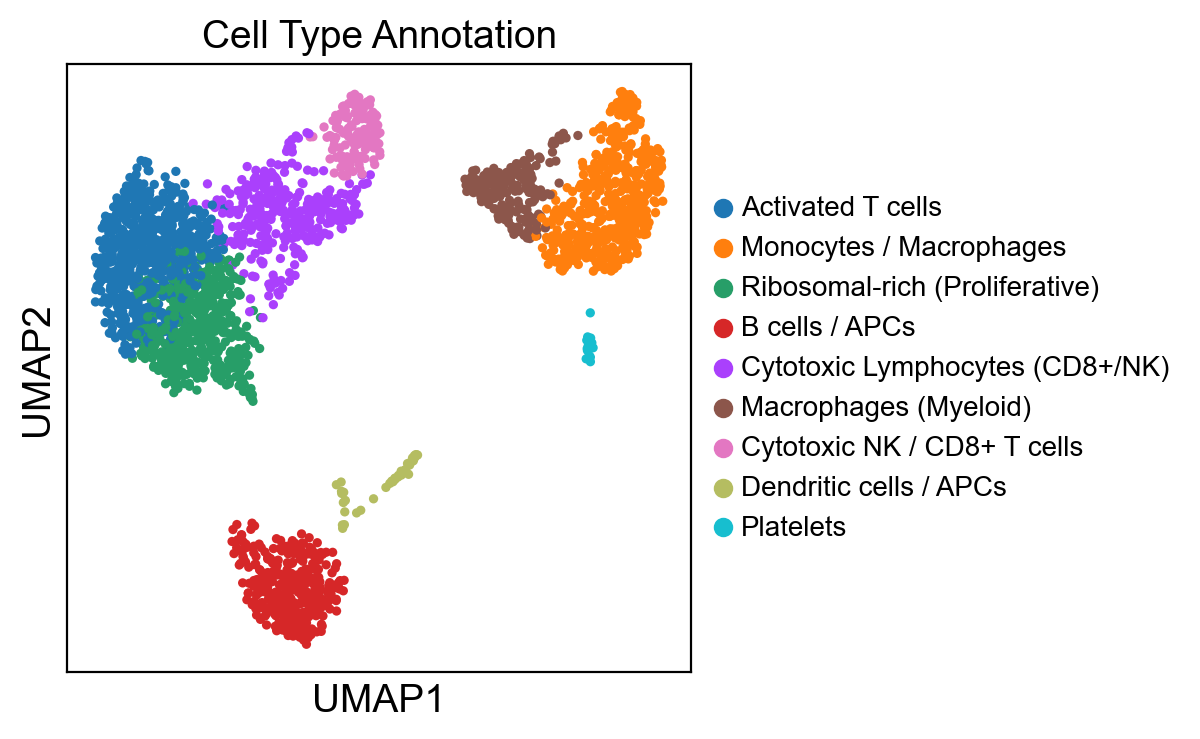

In [54]:
# Visualize annotated clusters on UMAP
sc.pl.umap(adata, color='cell_type', legend_loc='right margin', legend_fontsize=10, title='Cell Type Annotation')

/var/folders/dw/cp1c7tm95pldv_d3y5p478280000gn/T/ipykernel_20162/3369711413.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cell_type_counts.index, y=cell_type_counts.values, palette='Set2')


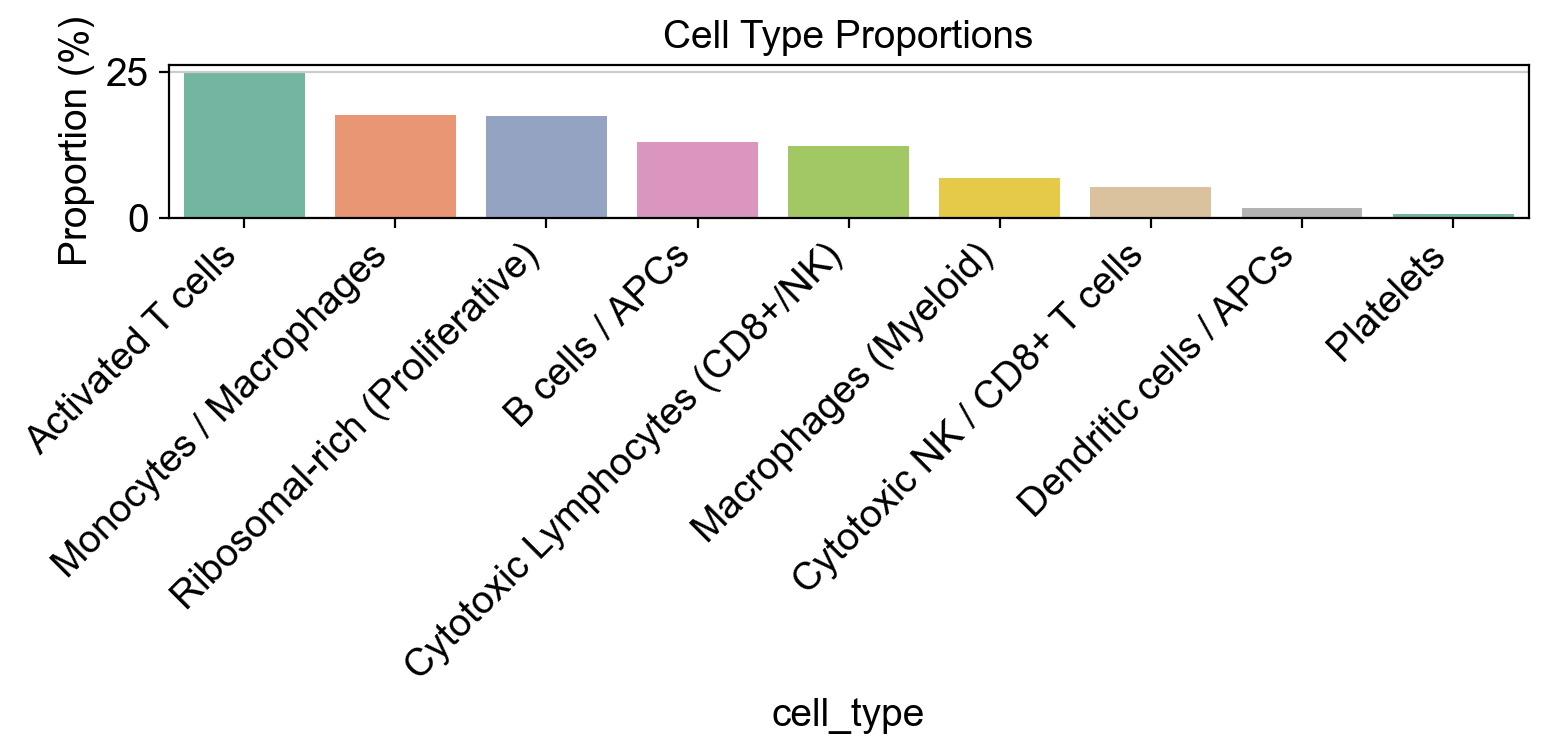

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count cell types
cell_type_counts = adata.obs['cell_type'].value_counts(normalize=True) * 100  # percentages

# Bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x=cell_type_counts.index, y=cell_type_counts.values, palette='Set2')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Proportions')
plt.tight_layout()
plt.show()
